# Serial Python

Before we get into parallel processing, let's first consider how the type of problems we'll consider are typically solved in a serial context. We'll focus on problems which always have the following form: 

In [2]:
def do_science(x):
    """For example:
    - training a neural network (hyperparameter tuning!)
    - getting results from a database
    - scraping some websites
    - reading files
    - sampling monte-carlo style
    """
    return x ** 2  # we don't really do anything ;)

results = []
input_data = range(10)
for x in input_data:
    results.append(do_science(x))
print(results)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


This typical structure (or "smell" ;) ) is pretty common and most likely all of you have something similar somewhere in your code. It's an excellent opportunity for leveraging parallelism to speed things up. However, first we'll rewrite this code using the builtin `map` function, it makes the code more compact and it will be easier to make this run in parallel. `map` takes a function and an iterable and applies the function to each iterable:

In [3]:
# when applying a function to a bunch of data, maybe you would use list comprehension
results = [do_science(x) for x in input_data]
print(results)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [4]:
# however, here we use map to later explore its parallel implementations
results = map(do_science, input_data)
results = list(results)
print(results)

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


(watch out: `map` returns an iterator (->advanced python), you need to convert it to a list explicitly).

### Questions?

## Exercise
Compute the cubes of numbers 0..9 using `map`.

In [6]:
input_data = range(10)
def cube(x):
    # TODO
    return x ** 3
results = map(cube, input_data)
list(results)

[0, 1, 8, 27, 64, 125, 216, 343, 512, 729]

Questions:
- What's the return type of `map`?
- Can we also compute the *sum* of numbers `0..9` using map? -> no(t trivially). results of operations depend on each other. this is a contra-indicator for "embarrassingly parallel" problems

# Embarassingly-parallel Python
This type of problem is referred to as "embarrassingly parallel" problems. This indicates that they can be easily parallelized across threads or processes as they do not require interaction while running (they can also be run in serial!). For these types of problems, we can use the builtin `multiprocessing` module. It supports parallel versions of `map` which can be run either in parallel threads or parallel processes.

## Parallel threads
We first work with the `ThreadPool` available from the `multiprocessing.pool` module. We assume CPython in which the GIL prevent several threads from executing in parallel. However, for some use cases, in particular those which are **I/O bound**, threading can be very useful. Consider for example obtaining data from some database: you would like to query a couple of measurements, and completing each of these queries may take some processing time on the server. Here we mimick this server-side processing time by merely sleeping.

In [26]:
from multiprocessing.pool import ThreadPool
import time

In [27]:
def query_database(x):
    """Query your database to retrieve awesome measurements."""
    print(f'querying data {x} start')
    time.sleep(x)  # mimicks (input-dependent) server-side processing
    y = x ** 2
    print(f'querying data {x} end')
    return y

In [30]:
input_data = [1, 8, 1.5, 2]  # some dummy queries

First, we use the builtin `map` function to perform the database query for each item in l:

In [31]:
%%time
result = list(map(query_database, input_data))
print(result)

querying data 1 start
querying data 1 end
querying data 8 start
querying data 8 end
querying data 1.5 start
querying data 1.5 end
querying data 2 start
querying data 2 end
[1, 64, 2.25, 4]
CPU times: user 2.76 ms, sys: 7.31 ms, total: 10.1 ms
Wall time: 12.5 s


Observations?
- queries processed in serial, one after the other
- total duration is the sum of the duration of each query 

Now, we use use `ThreadPool` do perform these queries using two threads (here the `processes` argument actually refers to the number of threads):

In [33]:
%%time
pool = ThreadPool(processes=2)
result = pool.map(query_database, input_data)
pool.close()

#with ThreadPool(processes=2) as pool:  # context manager providing a `ThreadPool` instance
#    result = pool.map(query_database, input_data)
#print(result)

querying data 1 start
querying data 8 start
querying data 1 end
querying data 1.5 start
querying data 1.5 end
querying data 2 start
querying data 2 end
querying data 8 end
CPU times: user 9.06 ms, sys: 8.41 ms, total: 17.5 ms
Wall time: 8.03 s


Observations?
- results are identical to serial processing of queries; good!
- total duration is reduced: work (here: waiting for results) is distributed across threads
- allocation: queries are performed in order; thread 0 works on query 0, thread 1 on query 1, thread 0 on the rest while thread 1 is busy with query 1
- caveat: optimal number of threads may be difficult to determine (depends on use case! more threads also means more switching!)
- caveat: load is not automatically ordered optimally (`ThreadPool` can not know how long each query takes); in our example if long query is the last, total duration increases

In [ ]:
input_data = [1, 1.5, 2, 8]  # some dummy queries

In [ ]:
%%time
with ThreadPool(processes=2) as pool:
    result = pool.map(query_database, input_data)
print(result)

### Questions?

## Exercise
A once-in-a-lifetime opportunity presents itself: you have access to a database holding secret information about ASPP. You can sent queries to it using the `query_secret_aspp_database` function, which expects a single (arbitrary) argument. First, implement a serial version, processing several (4+) queries. Then use the `ThreadPool` to parallelize your code. Time both versions and compare their execution times.

In [ ]:
from secret_aspp_database import query_secret_aspp_database

In [ ]:
%%time
# TODO fill me with the serial version
queries = ['42', 3.1415, 8162371823.123, 'pelita', 'ajwdiauwdiuahwiduhawdiuhawd']
list(map(query_secret_aspp_database, queries))

In [ ]:
%%time
# TODO fill me with the parallel version
with ThreadPool(processes=2) as pool:
    result = pool.map(query_secret_aspp_database, queries)
result

# Thread-parallel(?) number crunching
Now let's consider a compute-intense number-crunching task, for example tuning hyperparameters our fancy neural network model to squeeze out the additional 0.0002% increase in accuracy. Here we mimick the training by merely counting down from a large number (let's avoid cognitive overhead).

In [34]:
def train_neural_network(x):
    """Train your favourite neural network model."""
    print(f'training with {x} start')
    n = x * 2e7  # mimick compute-intense training
    while n > 0:
        n -= 1
    y = x ** 2
    print(f'training with {x} end')
    return y

In [35]:
input_data = [1, 8, 1.5, 2]  # some dummy simulations

Again, first, we use the builtin `map` function to perform the number crunching serially for each item in l:

In [36]:
%%time
result = list(map(train_neural_network, input_data))
print(result)

training with 1 start
training with 1 end
training with 8 start
training with 8 end
training with 1.5 start
training with 1.5 end
training with 2 start
training with 2 end
[1, 64, 2.25, 4]
CPU times: user 27.3 s, sys: 0 ns, total: 27.3 s
Wall time: 27.5 s


Observations:
- number crunching causes high CPU load (surprise! ;) )

Now, we use again use `ThreadPool` do parallelize this work using two threads:

In [37]:
%%time
with ThreadPool(processes=2) as pool:
    result = pool.map(train_neural_network, input_data)
print(result)

training with 1 starttraining with 8 start

training with 1 end
training with 1.5 start
training with 1.5 end
training with 2 start
training with 2 end
training with 8 end
[1, 64, 2.25, 4]
CPU times: user 26.3 s, sys: 0 ns, total: 26.3 s
Wall time: 26.8 s


Observations?
- runtime (almost) identical to serial execution: GIL prevents simultaneous number crunching. :'(

Questions:
- what is the return type of `pool.map`? -> list
- why is this different than the return type of `map`? -> normal map: delayed execution is desired, with pool you want to do the computation immediately (and in parallel)

# Parallel processes
For such tasks, we use the `ProcessPool`. In contrast to the `ThreadPool` this distributes work across multiple processes running separate instances of the Python interpreter. This allows you to circumvent the limitations of the GIL and achieve truly parallel code execution. For use cases which are **compute bound**, it is an excellent, simple-to-use option. As already introduced above, these use cases may include numerical simulations, sampling methods etc. Unfortunately, using multiple processes introduces some downsides, such as some overhead (time & memory) for launching processes and increased memory consumption (e.g., duplication of data; warning: depends on implementation and use case).

In [4]:
from multiprocessing.pool import Pool as ProcessPool

In [40]:
%%time
with ProcessPool(processes=2) as pool:  # context manager providing a `Pool` instance
    result = pool.map(train_neural_network, input_data)
print(result)

training with 1 start
training with 8 start
training with 1 end
training with 1.5 start
training with 1.5 end
training with 2 start
training with 2 end
training with 8 end
[1, 64, 2.25, 4]
CPU times: user 40.9 ms, sys: 0 ns, total: 40.9 ms
Wall time: 19.6 s


Observations?
- results are identical to serial and threaded execution; good!
- runtime is reduced compared to both serial and threaded execution
- increased CPU load on multiple cores
- caveat: as before, no automatic load balancing, tasks are executed in order

Questions:
- What is the fundamental difference between threads and processes? -> memory shared across threads, by default not across processes
- How does the data get from the main thread to the worker thread? -> shared memory (direct access)
- How does the data get from the main process to the worker process? -> communication (sending serialized data (in Python: pickle -> problems with stuff that's not picklable), or set up shared memory)

### Parallel speedup
So how much faster does my code become when I'm increasing the number of processes? Here we investigate the relative speedup ($T_\textrm{parallel} / T_\textrm{serial}$) for an increasing number of processes. We use the same compute-bound function as before, but remove some of the annoying output and make it a bit shorter.

In [45]:
import time
import numpy as np

def train_neural_network(x):
    """Train your favourite neural network model."""
    n = x * 1e6  # mimick compute-intense training
    while n > 0:
        n -= 1
    y = x ** 2
    return y


input_data = [2] * 16  # some dummy simulations of equal duration
times = []
n_processes = np.arange(1, 9)
for n in n_processes:
    t0 = time.time()
    with ProcessPool(processes=n) as pool:
        result = pool.map(train_neural_network, input_data)
    times.append(time.time() - t0)

times

[0.043039798736572266,
 0.03096604347229004,
 0.04002118110656738,
 0.04499959945678711,
 0.051397085189819336,
 0.05700969696044922,
 0.07579755783081055,
 0.07624220848083496]

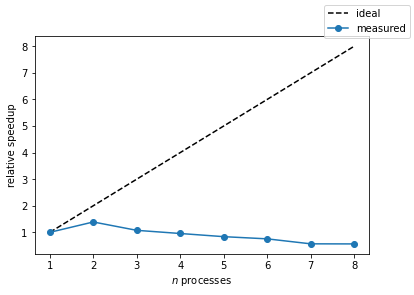

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

times = np.array(times)
fig, axes = plt.subplots()
axes.plot(n_processes, 1.0 * n_processes, color='k', linestyle='--', label='ideal')
axes.plot(n_processes, times[0] / times, marker='o', label='measured')
axes.set_xlabel(r'$n$ processes')
axes.set_ylabel('relative speedup')
fig.legend()

Observations
- perfect speedup with 2-3 processes, (on some machines) good speedup until ~4-5 processes with decreasing benefits
- no (significant) benefits for more processes
- rule of thumb: benefits up to number of cores (OS also needs some compute: context switching; also hyperthreading does not seem to work well in my experience)

Questions:
- Can we combine `ProcessPools` with `ThreadPools` in the worker processes? -> yes, but benefit depends on use case



# Exercise
Implement your own compute-bound function. Compare it's runtime for different numbers of processes, similar as in our example above. In particular investigate the case of "fast" compute-bound functions. Discuss your results.

In [7]:
def crunch_numbers(x):
    pass  # TODO replace with some number crunching

input_data = …   # TODO: replace with meaningful input to your function
times = []
for n_processes in range(1, 9):
    t0 = time.time()
    with ProcessPool(processes=n_processes) as pool:
        results = pool.map(crunch_numbers, input_data)
    times.append(time.time() - t0)

times

SyntaxError: invalid character in identifier (2696325191.py, line 4)

### Questions
- We get got a speedup. Could we get a slowdown?

# Multiprocessing, but with numpy
Let's consider a similar example as before (number crunching!) but now we leverage additional libraries to speed up the computation. In this example we will use numpy to perform maxtrix multiplications (dot products). To be fast, numpy (and many other libraries) rely on implementations of computationally expensive function in *compiled* language (e.g., C++). This is great, but unfortunately may interfere with multiprocessing at the Python level, since the compiled function can leverage parallelization too! To illustrate this point, let's consider a compute-intense function which just performs matrix multiplications. Again, we will compare the runtime of the serial with the parallel version (using multiple processes).

In [4]:
# import os
# os.environ["OMP_NUM_THREADS"] = "1"

from multiprocessing.pool import Pool as ProcessPool
import numpy as np
import time


def train_neural_network(m):
    """Train your favourite neural network model."""
    y = np.mean(np.dot(m, m))  # mimick compute-intense training
    return y

n = 3_000
# generate some random matrices as input
input_data = [np.random.randn(n, n), np.random.randn(n, n), np.random.randn(n, n), np.random.randn(n, n)]

In [5]:
%%time
result = list(map(train_neural_network, input_data))
result

CPU times: user 5.87 s, sys: 31.8 ms, total: 5.9 s
Wall time: 5.9 s


[0.02260239009863062,
 0.019099992856037504,
 0.0155115103447624,
 -0.003729112933788689]

In [6]:
%%time
with ProcessPool(processes=4) as pool:
    result = pool.map(train_neural_network, input_data)
print(result)

[0.02260239009863062, 0.019099992856037504, 0.0155115103447624, -0.003729112933788689]
CPU times: user 150 ms, sys: 194 ms, total: 344 ms
Wall time: 2.73 s


### Observations
- Duration does not change (might actually be a bit longer) if we use multiple processes.
- High load on all CPUs *even for the serial computation*. -> numpy parallelizes at a lower level
- Solution: limit the number of threads numpy can use via the `OMP_NUM_THREADS` environment variable.

## Resources
https://www.youtube.com/watch?v=AG1soUh4-nU
